## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [4]:
display(train.describe())

,age_approx,target,tfrecord,width,height,patient_code
count,33058.000000,33126.000000,33126.000000,33126.000000,33126.000000,33126.000000
mean,48.870016,0.017630,6.894826,4039.630381,2678.758256,734.894977
std,14.380360,0.131603,4.390486,2109.145590,1437.617626,528.907365
min,0.000000,0.000000,-1.000000,640.000000,480.000000,0.000000
25%,40.000000,0.000000,3.000000,1872.000000,1053.000000,271.000000
50%,50.000000,0.000000,7.000000,5184.000000,3456.000000,659.000000
75%,60.000000,0.000000,11.000000,6000.000000,4000.000000,1109.000000
max,90.000000,1.000000,14.000000,6000.000000,6000.000000,2055.000000


# Missing values

In [5]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
test['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
# anatom_site_general_challenge (NaN)
# train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [6]:
target_mean = train['target'].mean()
bias = 15
sex_age_mean_2 = train.groupby(['sex', 'age_approx'])['target'].agg(['mean', 'count']).reset_index()
sex_age_mean_2['sex_age_mean_2'] = ((sex_age_mean_2['mean']*sex_age_mean_2['count'])+(target_mean*bias))/(sex_age_mean_2['count']+bias)
train = train.merge(sex_age_mean_2[['sex', 'age_approx', 'sex_age_mean_2']], on=['sex','age_approx'], how='left')
test = test.merge(sex_age_mean_2[['sex', 'age_approx', 'sex_age_mean_2']], on=['sex','age_approx'], how='left')

train['sex_age_mean_2'].fillna(target_mean, inplace=True)
test['sex_age_mean_2'].fillna(target_mean, inplace=True)

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,sex_age_mean_2
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0,0.011699
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1,0.012273
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2,0.008710
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3,0.012273
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4,0.017098


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_age_mean_2
0,ISIC_0052060,IP_3579794,male,70.0,NaN,0.032975
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.007402
2,ISIC_0058510,IP_7960270,female,55.0,torso,0.017098
3,ISIC_0073313,IP_6375035,female,50.0,torso,0.008710
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.012273


# Training

In [7]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'train' if x['tfrecord'] in idxT else 'validation', axis=1)
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    # Evaludation
    preds = train['sex_age_mean_2']
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = test['sex_age_mean_2']
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Model evaluation

In [8]:
def func(x):
    if x['fold_1'] == 'validation':
        return x['pred_fold_1']
    elif x['fold_2'] == 'validation':
        return x['pred_fold_2']
    elif x['fold_3'] == 'validation':
        return x['pred_fold_3']
    elif x['fold_4'] == 'validation':
        return x['pred_fold_4']
    elif x['fold_5'] == 'validation':
        return x['pred_fold_5']
    
train['pred'] = train.apply(lambda x: func(x), axis=1)

auc_oof = roc_auc_score(train['target'], train['pred'])
print(f'Overall OOF AUC = {auc_oof:.3f}')

df_oof = train[['image_name', 'target', 'pred']]
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC = 0.696


,image_name,target,pred
0,ISIC_2637011,0,0.011699
1,ISIC_0015719,0,0.012273
2,ISIC_0052212,0,0.008710
3,ISIC_0068279,0,0.012273
4,ISIC_0074268,0,0.017098


,count,mean,std,min,25%,50%,75%,max
target,33126.0,0.01763,0.131603,0.000000,0.00000,0.000000,0.000000,1.000000
pred,33126.0,0.01740,0.015164,0.003889,0.00871,0.012938,0.020613,0.236127


# Model evaluation

In [9]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.695878,0.694771,0.001107,0.693514,0.703278,0.692343,0.707272,0.689392,0.721172,0.705446,0.657356,0.698695,0.684775
Accuracy,0.982228,0.982904,-0.000676,0.982222,0.982927,0.982223,0.982922,0.982211,0.982966,0.982236,0.982875,0.982247,0.982830
Precision,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1-score,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Support,464.800000,119.200000,345.600000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,464.000000,120.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.695878,0.694771,0.001107,0.693514,0.703278,0.692343,0.707272,0.689392,0.721172,0.705446,0.657356,0.698695,0.684775
male,0.683549,0.682374,0.001175,0.680688,0.696378,0.664190,0.746802,0.693626,0.644357,0.685473,0.675701,0.693770,0.648633
female,0.688253,0.683542,0.004711,0.678385,0.717329,0.702242,0.624772,0.662648,0.782731,0.711363,0.595427,0.686625,0.697450
head/neck,0.769065,0.776555,-0.007490,0.775790,0.723973,0.746230,0.880236,0.774156,0.756857,0.771529,0.766969,0.777621,0.754739
upper extremity,0.706431,0.701420,0.005011,0.700057,0.729380,0.712077,0.681716,0.693668,0.735171,0.716574,0.662233,0.709778,0.698599
lower extremity,0.625465,0.625558,-0.000093,0.620547,0.632974,0.631347,0.590267,0.620479,0.662174,0.631004,0.606793,0.623948,0.635583
torso,0.704062,0.702253,0.001810,0.696754,0.731801,0.698127,0.721663,0.702766,0.710216,0.714248,0.664392,0.708416,0.683192
0 <= age < 26,0.689253,0.682149,0.007104,0.702312,0.622034,0.741496,0.470141,0.666426,0.913194,0.651804,0.730849,0.684227,0.674527
26 <= age < 40,0.615093,0.606707,0.008387,0.607746,0.603127,0.611468,0.648743,0.627550,0.558934,0.633727,0.551972,0.594975,0.670758


# Visualize predictions

In [10]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 0
Train positive correct predictions: 0
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.011699,0.011699,0.011699,0.011699,0.011699,0.011699
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.012273,0.012273,0.012273,0.012273,0.012273,0.012273
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.008710,0.008710,0.008710,0.008710,0.008710,0.008710
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.012273,0.012273,0.012273,0.012273,0.012273,0.012273
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.017098,0.017098,0.017098,0.017098,0.017098,0.017098
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.006210,0.006210,0.006210,0.006210,0.006210,0.006210
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.021146,0.021146,0.021146,0.021146,0.021146,0.021146
7,ISIC_0075663,female,35.0,torso,unknown,0,0.009161,0.009161,0.009161,0.009161,0.009161,0.009161
8,ISIC_0075914,male,30.0,torso,unknown,0,0.017707,0.017707,0.017707,0.017707,0.017707,0.017707
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.008710,0.008710,0.008710,0.008710,0.008710,0.008710


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.017098,0.017098,0.017098,0.017098,0.017098,0.017098
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.008710,0.008710,0.008710,0.008710,0.008710,0.008710
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.016359,0.016359,0.016359,0.016359,0.016359,0.016359
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.028074,0.028074,0.028074,0.028074,0.028074,0.028074
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.027022,0.027022,0.027022,0.027022,0.027022,0.027022
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.069466,0.069466,0.069466,0.069466,0.069466,0.069466
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.009161,0.009161,0.009161,0.009161,0.009161,0.009161
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.088959,0.088959,0.088959,0.088959,0.088959,0.088959
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.028074,0.028074,0.028074,0.028074,0.028074,0.028074
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.017707,0.017707,0.017707,0.017707,0.017707,0.017707


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Visualize test predictions

In [11]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 0|10982
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.032975,0.032975,0.032975,0.032975,0.032975,0.032975
1,ISIC_0052349,male,40.0,lower extremity,0.007402,0.007402,0.007402,0.007402,0.007402,0.007402
2,ISIC_0058510,female,55.0,torso,0.017098,0.017098,0.017098,0.017098,0.017098,0.017098
3,ISIC_0073313,female,50.0,torso,0.008710,0.008710,0.008710,0.008710,0.008710,0.008710
4,ISIC_0073502,female,45.0,lower extremity,0.012273,0.012273,0.012273,0.012273,0.012273,0.012273
5,ISIC_0074618,male,50.0,lower extremity,0.016007,0.016007,0.016007,0.016007,0.016007,0.016007
6,ISIC_0076801,male,45.0,upper extremity,0.011699,0.011699,0.011699,0.011699,0.011699,0.011699
7,ISIC_0077586,male,50.0,lower extremity,0.016007,0.016007,0.016007,0.016007,0.016007,0.016007
8,ISIC_0082004,female,45.0,torso,0.012273,0.012273,0.012273,0.012273,0.012273,0.012273
9,ISIC_0082785,male,65.0,lower extremity,0.028074,0.028074,0.028074,0.028074,0.028074,0.028074


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Test set predictions

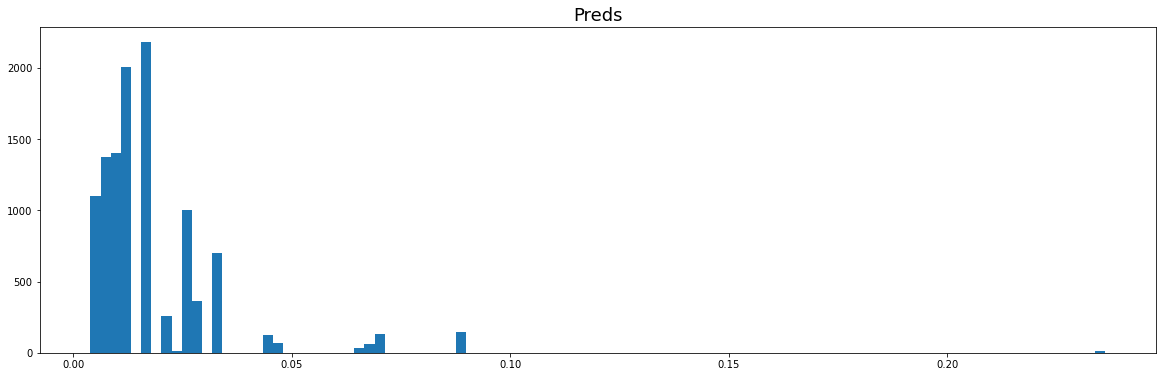

,image_name,target
0,ISIC_0052060,0.032975
1,ISIC_0052349,0.007402
2,ISIC_0058510,0.017098
3,ISIC_0073313,0.008710
4,ISIC_0073502,0.012273
5,ISIC_0074618,0.016007
6,ISIC_0076801,0.011699
7,ISIC_0077586,0.016007
8,ISIC_0082004,0.012273
9,ISIC_0082785,0.028074


,target
count,10982.000000
mean,0.017853
std,0.016213
min,0.003889
25%,0.008710
50%,0.012938
75%,0.021146
max,0.236127


In [12]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)